In [1]:
!python3 -m ipykernel install --user --name=env

Installed kernelspec env in /h/u14/c2/00/saragihd/.local/share/jupyter/kernels/env


In [13]:
# Load save 
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Load mnist
root = './data'
download = True
train_set = dset.MNIST(root=root, train=True, transform=None, download=download)
test_set = dset.MNIST(root=root, train=False, transform=None, download=download)

Label: 5
Image Size: (28, 28)
Numpy Shape: (28, 28)


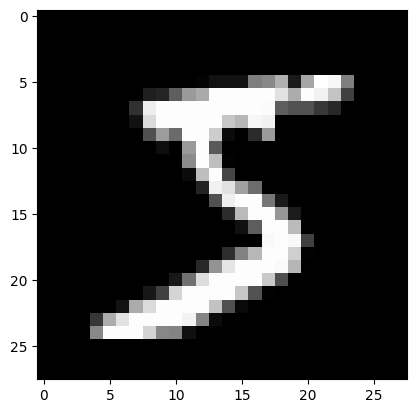

In [11]:
# Show data
def show(img):
    # Show image
    # Show with PIL
    plt.imshow(img, cmap='gray')
    plt.show()

# Get image
img, label = train_set[0]
print('Label:', label)
print('Image Size:', img.size)

# Convert to numpy
img = np.array(img)
print('Numpy Shape:', img.shape)

# Show image
show(img)

Transformed Shape: torch.Size([1, 28, 28])


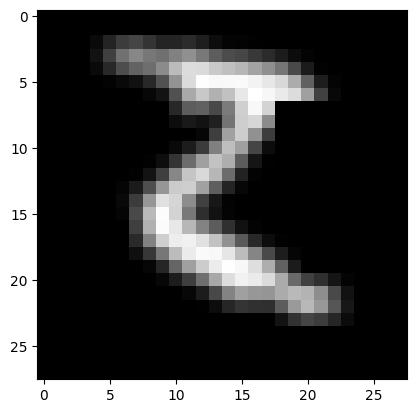

In [50]:
# Add colour jitter, random affine, random horizontal flip, random rotation, gaussian blur, random erasing, and normalization
transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.8),
    transforms.RandomRotation(15),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.9, scale=(0.02, 0.1)),
    transforms.Normalize((0.5,), (0.5,))
])

# Apply transform
img, label = train_set[0]
img = transform(img)
print('Transformed Shape:', img.size())

# Show image
img = img.permute(1, 2, 0)
img = img.numpy()
show(img)